# **<font color=red>AIR QUALITY AND RESPIRATOY DISEASES</font>**


### Background

* What is a Respiratory Disease? <br>
A type of disease that affects the lungs and other parts of the respiratory system. Respiratory diseases may be caused by infection, by smoking tobacco, or by breathing in secondhand tobacco smoke, radon, asbestos, or other forms of air pollution. Respiratory diseases include asthma, chronic obstructive pulmonary disease (COPD), pulmonary fibrosis, pneumonia, and lung cancer.


### Hypothesis

The air quality has an influence over respiratory diseases in Mexico City. We believe ozone (O$_3$) is the contaminant that causes most of the damage in people’s health as it is the pollutant that fluctuates more and the one that detonates environmental contingency when the threshold is surpassed. As PM10 (Particulate Matter 10 micrometers) is dangerous because of its small size, it is also considered to lead to respiratory diseases.
Within Mexico City, more industrialized municipalities (Iztapalapa, Iztacalco, Gustavo A. Madero) should show a higher level of pollution, therefore more cases of respiratory diseases.

### Assumptions and Limitations

* The analysis assumes that for medical emergencies, people attend to the closest hospital, which it is assumed is located in the zone where they spend significant amount of time and hence be affected by the quality of the air in that area.

* 2016 was the mos recent year of available information.


### Data Sources

#### Air pollution
* [Dirección de Monitoreo Atmosférico](http://www.aire.cdmx.gob.mx/default.php?opc=%27aKBhnmI=%27&opcion=Zg==)
    * Measurements per hour, day, month or year
    * Pollutant molecules ozone (O3), PM10(particulate matter 10 micrometers or less in diameter), oxides of nitrogen (NOx), carbon monoxide (CO)
    * Catalog of Monitoring Stations
    * Catalog of Parameters
    * Catalog of Measuring Units

* [Datos Abiertos de México Sobre Calidad del Aire API ](https://datos.gob.mx/blog/ventilando-datos-abiertos-sobre-calidad-del-aire)
    * Location of pollution monitoring stations (longitude, latitude) vs. measured pollutant molecules

#### Respiratory Diseases
* [Datos Abiertos Secretaría de Salud](https://datos.gob.mx/busca/dataset/urgencias)
    * Medical emergency cases from 2010 to 2016, filtered to include only respiratory emergencies located in Mexico City
    * Data on hospital entry date, age, gender, disease code, hospital code, length of stay, among others.
* [CLUES (Clave Única de Establecimientos de Salud) catalog](http://www.dgis.salud.gob.mx/contenidos/intercambio/clues_gobmx.html)
    * Information on each Hospital: Name, address, certification status, etc.
* [CIE-10 codes (Clasificación internacional de enfermedades)](http://cie10.org/index.html)
    * Catalog of disease codes in order to cross-reference to each patient disease.


#  Operating Stations in Mexico City

Using the extracted data from Dirección de Monitoreo Atmosférico del Gobierno de CDMX, we get the stations that are operating in Mexico City, their locations and the code name.

In [1]:
# Dependencies.
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d

import copy
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from numpy import zeros

In [2]:
# Retrieve stations csv file.
file_estaciones = "Resources/cat_estacion.csv"

# Read our Data file with the pandas library
cat_estaciones_df = pd.read_csv(file_estaciones, encoding="ISO-8859-1")
cat_estaciones_df.head()

,cve_estac,nom_estac,longitud,latitud,alt,obs_estac,id_station
0,ACO,Acolman,-98.912003,19.635501,2198.0,NaN,4.841500e+11
1,AJU,Ajusco,-99.162611,19.154286,2942.0,NaN,4.840900e+11
2,AJM,Ajusco Medio,-99.207744,19.272161,2548.0,NaN,4.840900e+11
3,ARA,Aragón,-99.074549,19.470218,2200.0,Finalizó operación en 2010,4.840900e+11
4,ATI,Atizapan,-99.254133,19.576963,2341.0,NaN,4.841500e+11


In [3]:
# Keep wanted columns
cat_estaciones_df = cat_estaciones_df[['cve_estac', 'nom_estac', 'longitud', 'latitud', 'obs_estac']]
cat_estaciones_df.head()

,cve_estac,nom_estac,longitud,latitud,obs_estac
0,ACO,Acolman,-98.912003,19.635501,NaN
1,AJU,Ajusco,-99.162611,19.154286,NaN
2,AJM,Ajusco Medio,-99.207744,19.272161,NaN
3,ARA,Aragón,-99.074549,19.470218,Finalizó operación en 2010
4,ATI,Atizapan,-99.254133,19.576963,NaN


From the created DataFrame we observe that some stations have stopped operations since 2010 and before. We need to get the stations that are still operating.

In [4]:
# Retrieve operating stations, rename columns and keep most important.
cat_estaciones_df = cat_estaciones_df.fillna('OK')

active_stations_df = cat_estaciones_df.loc[cat_estaciones_df['obs_estac'] == 'OK']
active_stations_df = active_stations_df[['cve_estac', 'nom_estac', 'longitud', 'latitud']]
active_stations_df = active_stations_df.rename(columns={'cve_estac' : 'Key',
                                                        'nom_estac' : 'Name',
                                                        'longitud' : 'Lng',
                                                        'latitud' : 'Lat'})
active_stations_df.head()

,Key,Name,Lng,Lat
0,ACO,Acolman,-98.912003,19.635501
1,AJU,Ajusco,-99.162611,19.154286
2,AJM,Ajusco Medio,-99.207744,19.272161
4,ATI,Atizapan,-99.254133,19.576963
7,CAM,Camarones,-99.169794,19.468404


In [5]:
# Extract stations codes already operating
active_stations_list = []
for station in active_stations_df['Key']:    
    active_stations_list.append(station)
print(f'Total of active stations: {len(active_stations_list)}')
# Printing codes of operating stations.
print(f'Codes of active stations: {active_stations_list}')

Total of active stations: 49
Codes of active stations: ['ACO', 'AJU', 'AJM', 'ATI', 'CAM', 'CCA', 'CHO', 'COR', 'COY', 'CUA', 'CUT', 'DIC', 'EAJ', 'EDL', 'FAC', 'GAM', 'HGM', 'IBM', 'INN', 'IZT', 'LAA', 'LLA', 'LOM', 'LPR', 'MCM', 'MER', 'MGH', 'MON', 'MPA', 'NEZ', 'PED', 'SAG', 'SFE', 'SHA', 'SJA', 'SNT', 'SUR', 'TAH', 'TEC', 'TLA', 'TLI', 'TPN', 'UAX', 'UIZ', 'UNM', 'VIF', 'XAL', 'FAR', 'SAC']


According to these tesults we found that:
* 20 Stations are not operating since 2010 and before
* 49 Stations are still in operation, we will focus on these ones.


The stations list created was done by taking the code of each operating station.From here, we can separate the current active stations that we get from the csv file of the stations. 

Now we can use an API to retrieve the measurements done by each of this active stations.

# API: Air Quality from Mexico

Using the API on the URL: https://datos.gob.mx/blog/ventilando-datos-abiertos-sobre-calidad-del-aire
we get data realated to these stations and the parameters measured by each one.

* To make this work it is necessary to install the module <font color=blue>datosgobmx</font> so it can be possible to make the calls to the API.
    * Run the command: **<font color=blue>pip install datosgobmx</font>**
    * Run the command: **<font color=blue>pip install folium</font>**

    
* First, retrieve the parameters that are measured by the stations


To make a call we simply use the function <font color=red>makeCall</font>, included in the module datosgobmx and pass the desired endpoint as parameter to the client. Then convert the returned json into a Pandas DataFrame. 
The returned info is the data provided through SINAICA from the meteorological stations.


In [6]:
# Dependencies
from datosgobmx import client 

- We first use <font color=blue>'sinacia-parametros'</font> as endpoint to get the **parameters** measured by the stations.

In [7]:
# Perform the call to the client to get the PARAMETERS measured.
params_request = client.makeCall('sinaica-parametros')

CALL: https://api.datos.gob.mx/v2/sinaica-parametros
{'pagination': {'pageSize': 100, 'page': 1, 'total': 7}, 'results': [{'_id': '5c2aa3dfe2705c1932134299', 'parametro': 'CO', 'date-insert': '2018-12-31T23:18:55.923Z'}, {'_id': '5c2aa3dfe2705c193213429a', 'parametro': 'O3', 'date-insert': '2018-12-31T23:18:55.923Z'}, {'_id': '5c2aa3dfe2705c193213429b', 'parametro': 'PM10', 'date-insert': '2018-12-31T23:18:55.923Z'}, {'_id': '5c2aa3dfe2705c193213429c', 'parametro': 'SO2', 'date-insert': '2018-12-31T23:18:55.923Z'}, {'_id': '5c2aa3dfe2705c193213429d', 'parametro': 'NO2', 'date-insert': '2018-12-31T23:18:55.923Z'}, {'_id': '5c2aa3dfe2705c193213429e', 'parametro': 'PM2.5', 'date-insert': '2018-12-31T23:18:55.923Z'}, {'_id': '5c2aa3dfe2705c193213429f', 'parametro': 'TMP', 'date-insert': '2018-12-31T23:18:55.923Z'}]}


In [8]:
# Convert the obtained json into a DataFrame.
params_measured = []

for v in params_request['results']:
    aux = pd.DataFrame.from_dict(v, orient='index').T
    params_measured.append(aux)

params_measured = pd.concat(params_measured, ignore_index=True)
params_measured['date-insert'] = pd.to_datetime(params_measured['date-insert'])
params_measured

,_id,parametro,date-insert
0,5c2aa3dfe2705c1932134299,CO,2018-12-31 23:18:55.923
1,5c2aa3dfe2705c193213429a,O3,2018-12-31 23:18:55.923
2,5c2aa3dfe2705c193213429b,PM10,2018-12-31 23:18:55.923
3,5c2aa3dfe2705c193213429c,SO2,2018-12-31 23:18:55.923
4,5c2aa3dfe2705c193213429d,NO2,2018-12-31 23:18:55.923
5,5c2aa3dfe2705c193213429e,PM2.5,2018-12-31 23:18:55.923
6,5c2aa3dfe2705c193213429f,TMP,2018-12-31 23:18:55.923


These DataFrame, shows the 7 parametes measured by the stations according to the API provided.

- Now, we use <font color=blue>'sinaica-estaciones'</font> as the endpoint, to get all the stations from the API. The parameter <font color=blue>'pageSize'</font> is the number of results that we want the API to give us. In this case, there are 185 stations in the data base, so we give a bigger number to make sure it will return all of them.

In [9]:
# Now, retrieve all stations and locations in the country by calling the air quality API provided.
# The dependencie used is datosgobmx input at the beginning of the notebook.
params_estaciones = client.makeCall('sinaica-estaciones', {'pageSize':200})

CALL: https://api.datos.gob.mx/v2/sinaica-estaciones?pageSize=200
{'pagination': {'pageSize': 200, 'page': 1, 'total': 185}, 'results': [{'_id': '5cad51c3e2705c19320ec0ee', 'lat': 21.873311111111, 'long': -102.32080277778, 'id': 31, 'nombre': 'CBTIS\xa0', 'codigo': 'CBT', 'redesid': 30, 'date-insert': '2019-04-10T02:15:31.835Z'}, {'_id': '5cad51c3e2705c19320ec0ef', 'lat': 21.846391666667, 'long': -102.28843055556, 'id': 32, 'nombre': 'Secretaría de Medio Ambiente', 'codigo': 'SMA', 'redesid': 30, 'date-insert': '2019-04-10T02:15:31.838Z'}, {'_id': '5cad51c3e2705c19320ec0f0', 'lat': 21.883780555556, 'long': -102.295825, 'id': 33, 'nombre': 'Centro', 'codigo': 'CEN', 'redesid': 30, 'date-insert': '2019-04-10T02:15:31.838Z'}, {'_id': '5cad51c3e2705c19320ec0f1', 'lat': 32.639722222222, 'long': -115.50638888889, 'id': 39, 'nombre': 'COBACH', 'codigo': 'SPABC14', 'redesid': 32, 'date-insert': '2019-04-10T02:15:31.838Z'}, {'_id': '5cad51c3e2705c19320ec0f2', 'lat': 32.603638888889, 'long': -11

In [10]:
# Create a DataFrame of this stations. 
stations_params = []
for v in params_estaciones['results']:
    aux = pd.DataFrame.from_dict(v, orient='index').T
    stations_params.append(aux)

stations_params = pd.concat(stations_params, ignore_index=True)
stations_params['date-insert'] = pd.to_datetime(stations_params['date-insert'])
stations_params.head()

,_id,lat,long,id,nombre,codigo,redesid,date-insert
0,5cad51c3e2705c19320ec0ee,21.8733,-102.321,31,CBTIS,CBT,30,2019-04-10 02:15:31.835
1,5cad51c3e2705c19320ec0ef,21.8464,-102.288,32,Secretaría de Medio Ambiente,SMA,30,2019-04-10 02:15:31.838
2,5cad51c3e2705c19320ec0f0,21.8838,-102.296,33,Centro,CEN,30,2019-04-10 02:15:31.838
3,5cad51c3e2705c19320ec0f1,32.6397,-115.506,39,COBACH,SPABC14,32,2019-04-10 02:15:31.838
4,5cad51c3e2705c19320ec0f2,32.6036,-115.486,41,CESPM,SPABC19,32,2019-04-10 02:15:31.838


This DataFrame shows every station in the Country (total of 185). We have to perform some operations to get the stations that are still operating in Mexico City.

This will be made by using the list of operating stations created in the first part of the notebook.

In [11]:
# Select rows whose column value is in OPERATING STATIONS list. 
stations_params.to_csv('Outputs/data_stations_sinaica.csv')
stations_params = stations_params.loc[stations_params['codigo'].isin(active_stations_list)]
operating_stations_params_df = stations_params.iloc[16:]

stations_codes_list = stations_params['codigo'].tolist()
print(stations_codes_list)

['SUR', 'TEC', 'CAM', 'SAG', 'TEC', 'ATI', 'SFE', 'TLA', 'TEC', 'TEC', 'TEC', 'COR', 'TEC', 'TEC', 'TEC', 'TEC', 'ACO', 'AJU', 'AJM', 'ATI', 'CAM', 'CCA', 'CHO', 'COY', 'CUA', 'CUT', 'FAC', 'HGM', 'IZT', 'LPR', 'LLA', 'MER', 'MON', 'NEZ', 'PED', 'SAG', 'SFE', 'MGH', 'TAH', 'TLA', 'TLI', 'UIZ', 'UAX', 'VIF', 'XAL', 'CHO', 'MPA', 'INN', 'GAM', 'SUR', 'SUR', 'FAR', 'SAC']


In [12]:
# Keep operating stations in the DataFrame.
operating_stations_df = operating_stations_params_df.drop([142,179])

# Keep and rename wanted to columns for better understanding.
operating_stations_df = operating_stations_df[['lat', 'long', 'id', 'nombre', 'codigo']]
operating_stations_df = operating_stations_df.rename(columns={'lat'  : 'Lat',
                                                              'long' : 'Lng',
                                                              'id' : 'id',
                                                              'nombre' : 'Name',
                                                              'codigo' : 'Key'
})

operating_stations_df = operating_stations_df[['id', 'Key', 'Name', 'Lat', 'Lng']]
operating_stations_df['id']=operating_stations_df['id'].astype(int)
operating_stations_df.head()

,id,Key,Name,Lat,Lng
109,240,ACO,Acolman,19.6356,-98.9122
110,241,AJU,Ajusco,19.1543,-99.1628
111,242,AJM,Ajusco Medio,19.2722,-99.2078
112,243,ATI,Atizapán,19.5772,-99.2542
113,244,CAM,Camarones,19.4686,-99.17


* The next step in this Notebook is to bring all parameters measured by each station. We have found that not every staion meaures all parameters. Then we need to see which station measures which parameter to help us visualize and have a strong analysis when we compare and study the rest of the data.

In [13]:
# Store operating stations in a list.
stations_id = operating_stations_df['id'].tolist()
stations_names = operating_stations_df['Name'].tolist()

# Create a DataFrame with id and name of stations.
list_of_tuples = list(zip(stations_id, stations_names))
id_names_df = pd.DataFrame(list_of_tuples, columns = ['id', 'Name'])
id_names_df.head()

,id,Name
0,240,Acolman
1,241,Ajusco
2,242,Ajusco Medio
3,243,Atizapán
4,244,Camarones


Now, we need to make calls to bring the parameters measured by each stations. These calls are made in real-time so it brings the last measured get in the data.

To make a call for this we use the next structure:
* client.makeCall('sinaica', {'pageSize':5000, 'parametro':'O3', 'estacionesid':259, 'page':1})

Where, **pageSize** is the number of results we want, **parametro** is the parameter we wanto to see the measure, **estacionesid** is the id of the station we want to see, and **page** is the number of the json page we want to bring in case we want to retrieve historical data.

If, no paramenter brought means station doesn't take that measured. Then it will no be added to the DataFrame.

Using this code it takes to much time to get the data. However, we can make calls and bring just 1 result for each parameter and station. We do this, because we just want thetype of parameters measured by each station.

## Retrieve one measure for each station and paramenter.


params_and_stations_co = []

for e in stations_id:
    
    data_api = client.makeCall('sinaica', {'pageSize':1, 'parametro':'XX', 'estacionesid':e, 'page':3})
    
    for v in data_api['results']:
        aux = pd.DataFrame.from_dict(v, orient='index').T
        params_and_stations_co.append(aux)
    
params_and_stations_XX = pd.concat(params_and_stations_co, ignore_index=True)

Note: We need to run this loop 7 times, changing each time XX to the corresponding parameter in: ['CO', 'O3', 'PM10', 'SO2', 'NO2', 'PM2.5', 'TMP'] This is due to the API from the government tends to fail when doing a lot of consecutive calls.
Then save each data frame we get into a csv file:
params_and_stations_XX.to_csv('params_stations_index_XX.csv', index=False)

Once we have finished making the calls, we keep the results in a csv file to make a later use of them.


## Setup Stations and Parameters measured.

In [14]:
# New Dependencies
import json

# Retrieve stations csv file.
co_measured = 'Resources/params_stations_index_co.csv'
no2_measured = 'Resources/params_stations_index_no2.csv'
o3_measured = 'Resources/params_stations_index_o3.csv'
pm2_measured = 'Resources/params_stations_index_pm2.csv'
pm10_measured = 'Resources/params_stations_index_pm10.csv'
so2_measured = 'Resources/params_stations_index_so2.csv'
tmp_measured = 'Resources/params_stations_index_tmp.csv'

co_measured_df = pd.read_csv(co_measured, encoding="ISO-8859-1")
no2_measured_df = pd.read_csv(no2_measured, encoding="ISO-8859-1")
o3_measured_df = pd.read_csv(o3_measured, encoding="ISO-8859-1")
pm2_measured_df = pd.read_csv(pm2_measured, encoding="ISO-8859-1")
pm10_measured_df = pd.read_csv(pm10_measured, encoding="ISO-8859-1")
so2_measured_df = pd.read_csv(so2_measured, encoding="ISO-8859-1")
tmp_measured_df = pd.read_csv(tmp_measured, encoding="ISO-8859-1")

co_measured_df = co_measured_df[['parametro', 'estacionesid']]
no2_measured_df = no2_measured_df[['parametro', 'estacionesid']]
o3_measured_df = o3_measured_df[['parametro', 'estacionesid']]
pm2_measured_df = pm2_measured_df[['parametro', 'estacionesid']]
pm10_measured_df = pm10_measured_df[['parametro', 'estacionesid']]
so2_measured_df = so2_measured_df[['parametro', 'estacionesid']]
tmp_measured_df = tmp_measured_df[['parametro', 'estacionesid']]

# Concatenate all data in a single one.
stations_df_full = pd.concat([co_measured_df, no2_measured_df], ignore_index=True)
stations_df_full = pd.concat([stations_df_full, o3_measured_df], ignore_index=True)
stations_df_full = pd.concat([stations_df_full, pm2_measured_df], ignore_index=True)
stations_df_full = pd.concat([stations_df_full, pm10_measured_df], ignore_index=True)
stations_df_full = pd.concat([stations_df_full, so2_measured_df], ignore_index=True)
stations_df_full = pd.concat([stations_df_full, tmp_measured_df], ignore_index=True)
stations_df_full.count()

parametro       178
estacionesid    178
dtype: int64

In [15]:
# Get the station id and the paramenter from the read csv files. This is one lecture of each
# parameter from each station who reads that parameter.
stations_df_full = stations_df_full.rename(columns={'parametro' : 'Parameter',
                                                    'estacionesid' : 'id'
})
stations_df_full.head()

,Parameter,id
0,CO,240
1,CO,242
2,CO,243
3,CO,244
4,CO,245


#### Merging DataFrames to get Names and Parameters

In [16]:
merging_id_df = id_names_df.merge(stations_df_full)
merging_id_df['id']=merging_id_df['id'].astype(int)
merging_id_df.head(5)

,id,Name,Parameter
0,240,Acolman,CO
1,240,Acolman,NO2
2,240,Acolman,O3
3,240,Acolman,PM10
4,240,Acolman,SO2


In [17]:

# Create new DF with Nombre, Lat, Lng, Parametro, id
merging_names_df = merging_id_df.merge(operating_stations_df)
#merging_names_df
merging_names_df = merging_names_df[['Name', 'Lng', 'Lat','Parameter', 'id']]
merging_names_df.head()

,Name,Lng,Lat,Parameter,id
0,Acolman,-98.9122,19.6356,CO,240
1,Acolman,-98.9122,19.6356,NO2,240
2,Acolman,-98.9122,19.6356,O3,240
3,Acolman,-98.9122,19.6356,PM10,240
4,Acolman,-98.9122,19.6356,SO2,240


In [18]:
# Set id as an index and Parameters as columns.
id_df = pd.crosstab(merging_names_df['id'], merging_names_df['Parameter'].fillna('n/a'))

# Join parameters for each id station. Reset index for id.
parameters_df = id_df.reset_index()

# GET the last form of the DataFrame. Drop Parameter as an index name. Set it as a column.
final_stations_params_df = parameters_df.merge(merging_names_df)

# Delete repeated rows keeping first occurence in column 'Nombre'
final_stations_params_df.drop_duplicates(subset ="Name", keep = 'first', inplace = True) 

# Delete column 'Parametro'
del final_stations_params_df['Parameter']

# Reorder columns to get a better understanding and better appeal.
final_stations_params_df = final_stations_params_df[['id', 'Name', 'Lat', 'Lng', 'CO', 'NO2', 'O3', 'PM10', 'PM2.5', 'SO2', 'TMP']]
final_stations_params_df = final_stations_params_df[['id', 'Name', 'Lat', 'Lng', 'CO', 'NO2', 'O3', 'PM10', 'PM2.5', 'SO2', 'TMP']]
final_stations_params_df.head()

,id,Name,Lat,Lng,CO,NO2,O3,PM10,PM2.5,SO2,TMP
0,240,Acolman,19.6356,-98.9122,1,1,1,1,0,1,0
5,241,Ajusco,19.1543,-99.1628,0,0,1,0,1,0,1
8,242,Ajusco Medio,19.2722,-99.2078,1,1,1,1,1,1,1
15,243,Atizapán,19.5772,-99.2542,1,1,1,0,0,1,0
19,244,Camarones,19.4686,-99.17,1,1,1,1,1,1,0


Final Stations Params DataFrame indicates, id, name, latitude and longitude for each operating station.
Also it tells which parameter is read by each station: 1 means it reads the parameter.

## Mapping Stations: location and parameters

In [19]:
# Dependencies for folium module.
import folium
m = folium.Map(location=[19.3911668, -99.4238175])
centro_lat, centro_lon = 19.42472, -99.11972
folium_map = folium.Map(location=[centro_lat, centro_lon], zoom_start = 10, tiles='cartodb positron')

for i, row in final_stations_params_df.iterrows():
    params = []
    
    if row.CO == 1:
        params.append('CO')
    if row.NO2 == 1:
        params.append('NO2')
    if row.O3 == 1:
        params.append('O3')
    if row.PM10 == 1:
        params.append('PM10')
    if row['PM2.5'] == 1:
        params.append('PM2.5')
    if row.SO2 == 1:
        params.append('SO2')
    if row.TMP == 1:
        params.append('TMP')
    
    
    popup_text = f'<b> Nombre: </b> {row.Name} <br> \
                  <b> Latitud: </b> {row.Lat:.5f} <br> \
                  <b> Longitud: </b> {row.Lng:.5f} <br> \
                  <b> Parametros: </b>   {params}'
    folium.CircleMarker(location=[row.Lat, row.Lng], radius=5,
                       tooltip=popup_text, fill=True, fill_opacity=0.4).add_to(folium_map)

folium_map.save('Outputs/cdmx_stations.html')

In [20]:
folium_map

# Air Quality insights

This section summarizes the analysis made about air pollution by municipalities and presents the following insights:
* Provide a better representation of the missing data from 2014 to 2016
* Look for the most polluted municipalities in 2016

The Air Quality data processing details are shown in the notebook "Pollutants_Analysis_and_Insights"

In [21]:
#Select Mexico City municipalities
stations =["Alvaro Obregon", "Azcapotzalco", "Benito Juarez", "Coyoacan",\
"Cuajimalpa de Morelos", "Cuauhtemoc", "Gustavo A Madero", "Iztacalco", "Iztapalapa", \
"Miguel Hidalgo", "Milpa Alta", "Tlalpan", "Venustiano Carranza", "Xochimilco"]

#Create dictionaries to store the data for plotting
stations_pivot_month = {}
stations_pivot_year = {}
number_of_years=3

#Select only ozone and particle matter for the analysis
selected_parameters=['O3', 'PM10']

In [22]:
#Store the data for plotting
for station in stations:
    filen="./Resources/pollution_missing_data/"+station+".csv"
    df= pd.read_csv(filen, encoding="ISO-8859-1")
    df= df.set_index("month_and_year")
    stations_pivot_month[station]= df

for station in stations:
    filen="./Resources/pollution_2016/"+station+".csv"
    df= pd.read_csv(filen, encoding="ISO-8859-1")
    stations_pivot_year[station]= df

Plot to provide a better representation of the missing data from 2014 to 2016

In [23]:
#Prepare data to create the plot that displays the missing data over time

townships_parameters_month = {}
date = []
month_plot=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
year_plot=[ "2014","2015", "2016"]

for yp in year_plot:
    for m in month_plot:
        date.append(f"{m} {yp}")

initialize_parameters_df1 = pd.DataFrame(columns=['D', "Date"])
initialize_parameters_df1["Date"]= date
initialize_parameters_df1.set_index(initialize_parameters_df1['Date'], inplace=True)

for station in stations:
    initialize_parameters_df = pd.DataFrame(columns=['Date',  'O3', 'PM10'])
    d = stations_pivot_month[station]
    
    for parameter in selected_parameters:
        if parameter in d:
            exist = True
        else:
            exist = False
        if exist == True:
            if parameter == 'CO':
                initialize_parameters_df.loc[:,parameter] = (d.loc[:,parameter])*100
            else:
                initialize_parameters_df.loc[:,parameter] = d.loc[:,parameter]  
        if exist == False:
                length = len(initialize_parameters_df.loc[:,parameter])
                if length == 0: 
                    initialize_parameters_df.loc[:,parameter] = np.empty(number_of_years*12)
                    initialize_parameters_df["Date"] = date
                    initialize_parameters_df.set_index(initialize_parameters_df['Date'], inplace=True)
                else:
                    initialize_parameters_df.loc[:,parameter] = np.empty(length)
                    
    merge_table = pd.merge(initialize_parameters_df1, initialize_parameters_df, left_index=True, right_index=True, how="left")
    townships_parameters_month[station] = merge_table

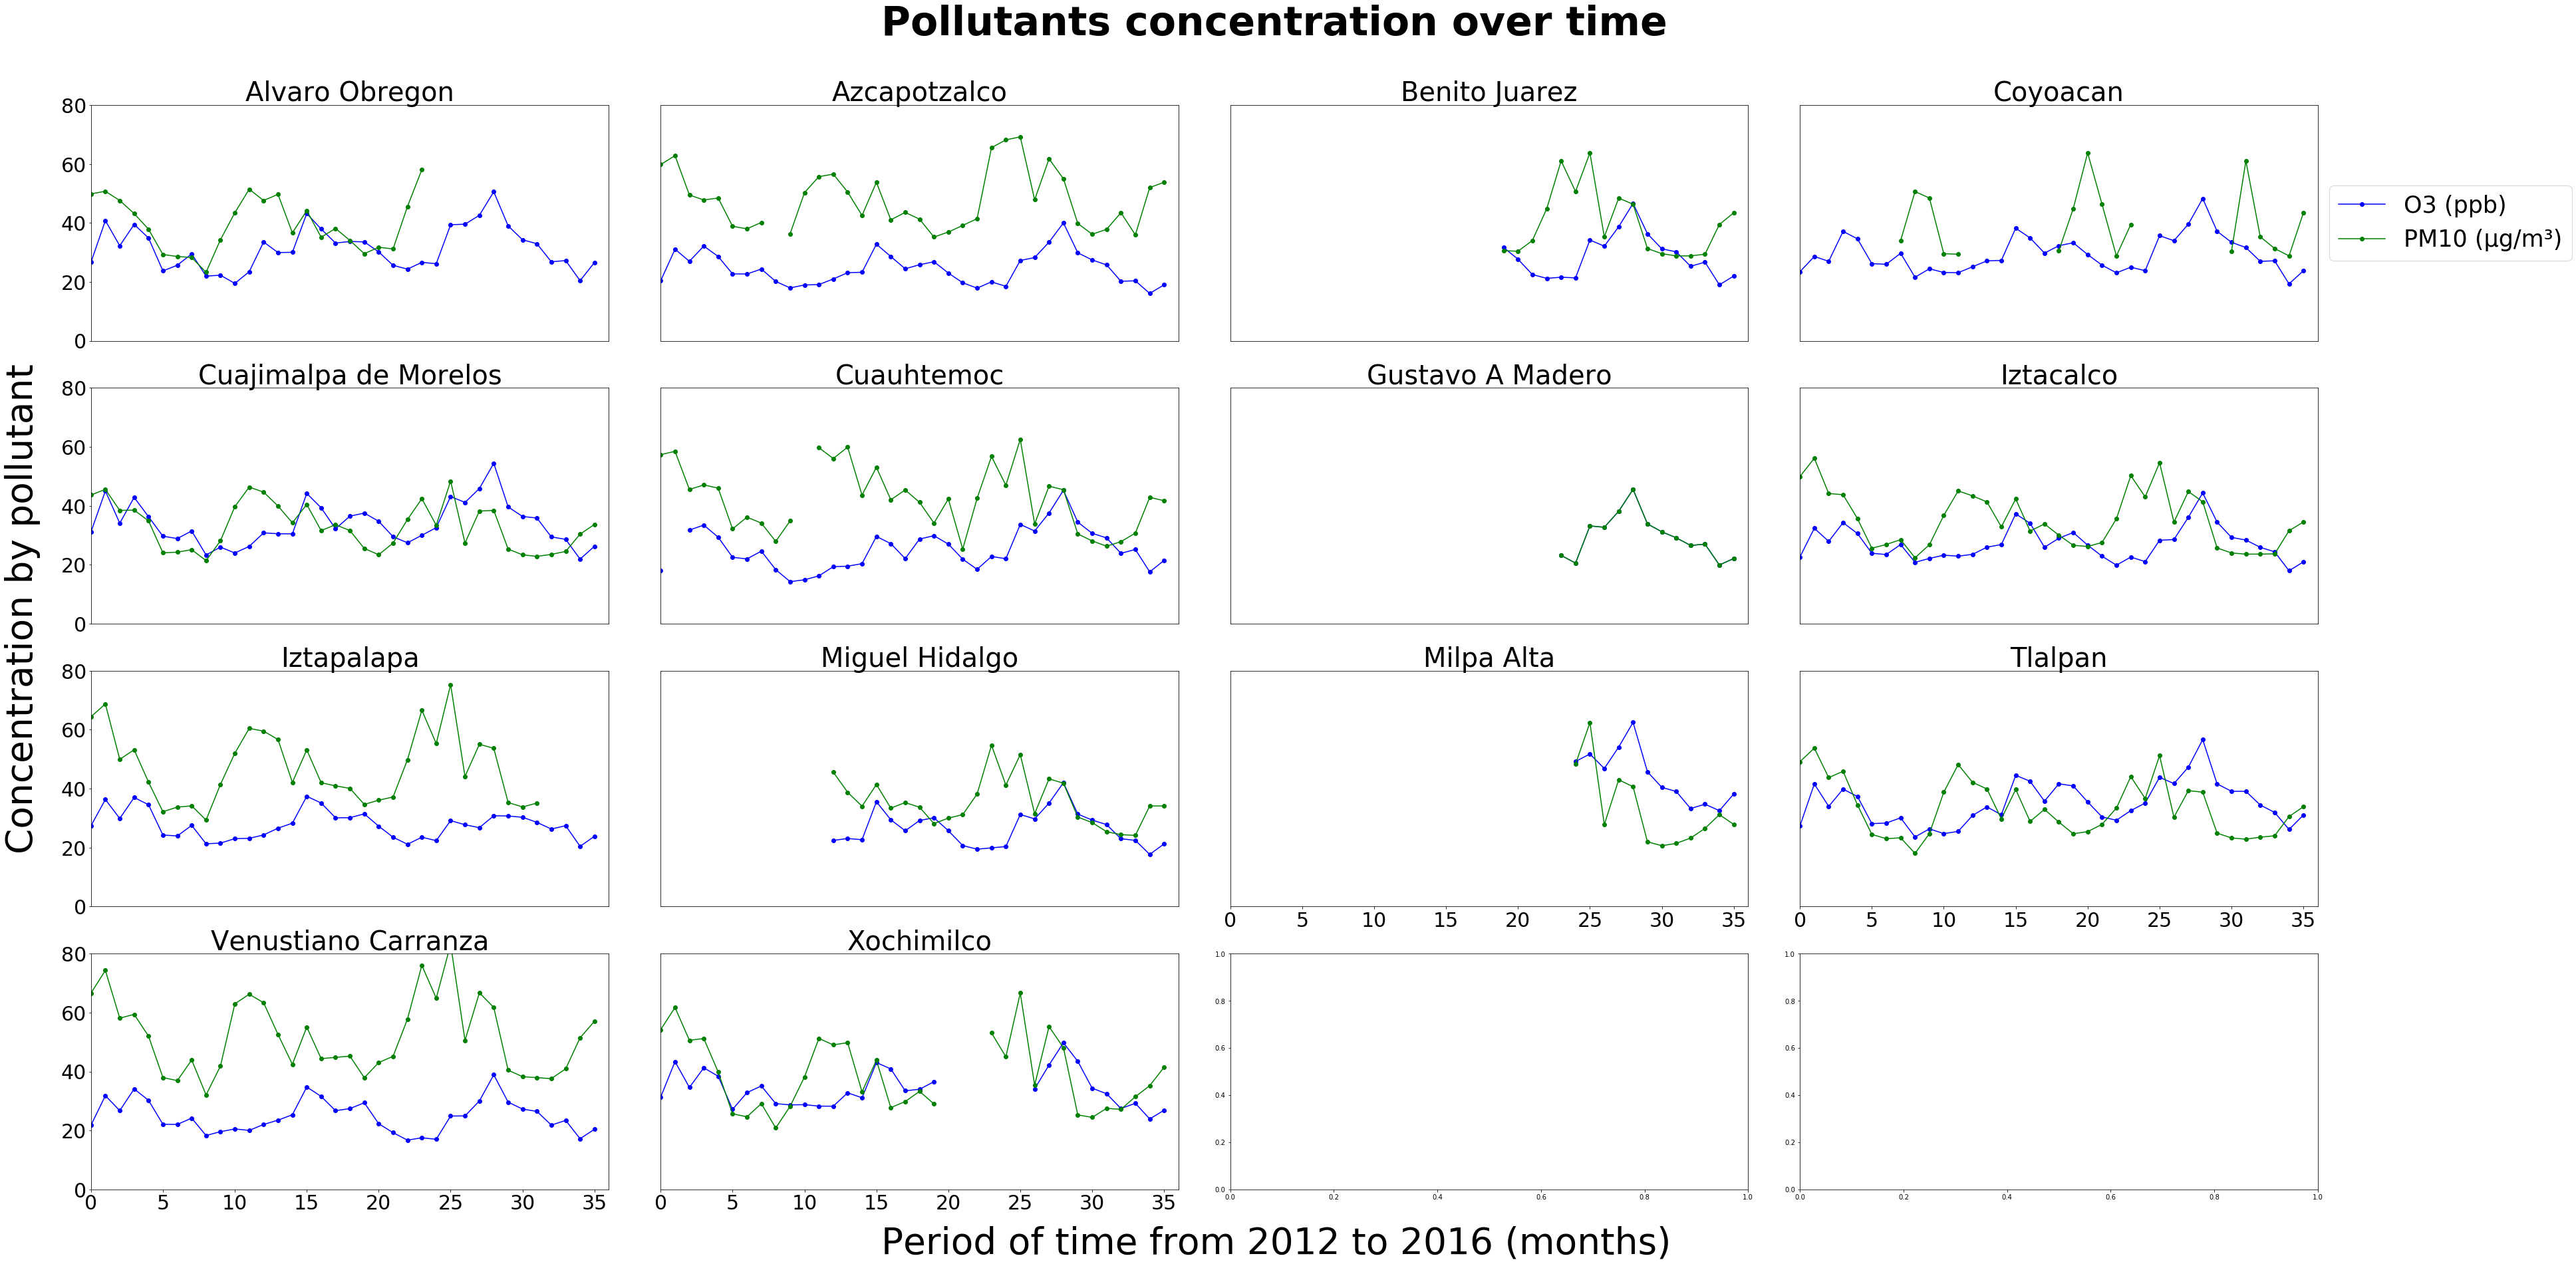

In [24]:
#Plot the average pollutant parameters by month per municipality

fig, axes = plt.subplots(nrows = 4, ncols = 4,  figsize = (60,30))
colors= ["blue", "green"]
selected_units=['ppb', 'µg/m³']
leg=0
plt.subplots_adjust(wspace=.1, # wspace controls the width of space between subplots
                    hspace=0.2)
for ax, station in zip(axes.flat, stations):
    counter=0
    d = townships_parameters_month[station]
    d = pd.DataFrame(d).reset_index()
    
    for i in range(len(colors)):        
        ax.plot( d.index, d.loc[:,selected_parameters[counter]].values, color=colors[counter],\
                label = f"{selected_parameters[counter]} ({selected_units[counter]})", marker="o")

        counter += 1
    ax.axis([0,number_of_years*12 , 0, 80])
    

    ax.tick_params('y', colors='black', labelsize=30)
    ax.tick_params('x', colors='black', labelsize=30)
    ax.xaxis.set_visible(True)
    #ax.title.set_text(station)
    ax.set_title(station , size=40)
    ax.yaxis.set_visible(False)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=35)
    
    if leg != 3:
        ax.get_legend().remove()
        
    if leg < 10:
        ax.xaxis.set_visible(False)
        
    if leg == 0:  
        ax.yaxis.set_visible(True)
    if leg == 4:  
        ax.yaxis.set_visible(True)
    if leg == 8:  
        ax.yaxis.set_visible(True)
    if leg == 12:  
        ax.yaxis.set_visible(True)
        
    leg=leg+1
    
fig.text(0.4, .95, "Pollutants concentration over time",
        verticalalignment='top', horizontalalignment='left',
        color='black', fontsize=60, fontweight='bold')

fig.text(0.095, .7, "Concentration by pollutant",
        verticalalignment='top', horizontalalignment='left',
        color='black', fontsize=55, rotation="vertical")

fig.text(0.4, .1, "Period of time from 2012 to 2016 (months)",
        verticalalignment='top', horizontalalignment='left',
        color='black', fontsize=55)

plt.savefig("./images/Township_by_2014-2016_O3_pm10.png")
plt.show()

Conclusions: 
* There is no data for Gustavo A. Madero 
* Alvaro Obregon and Coyoacan has few data about particle matter
* There is also few data about Milpa Alpa


Plot to look for the most polluted municipalities in 2016 considering that we do not have information about Gustavo A. Madero

In [25]:
#Create the data frame to look for the most polluted municipalities in a specific year or a range of years.
townships_parameters_year = {}

for station in stations:
    initialize_parameters_df = pd.DataFrame(columns=['Date',  'O3', 'PM10'])
    d = stations_pivot_year[station]
    
    for parameter in selected_parameters:
        if parameter in d:
            exist = True
        else:
            exist = False
            
        if exist == True:
            if parameter == 'CO':
                initialize_parameters_df.loc[:,parameter] = (d.loc[:,parameter])
            else:
                initialize_parameters_df.loc[:,parameter] = d.loc[:,parameter]
        if exist == False:
                length = len(initialize_parameters_df.loc[:,parameter])
                if length == 0: 
                    initialize_parameters_df.loc[:,parameter] = np.empty(number_of_years)
                else:
                    initialize_parameters_df.loc[:,parameter] = np.empty(length)
        
    townships_parameters_year[station] = initialize_parameters_df

In [26]:
#Remove Gustavo A. Madero from the analysis because there is no relevant data about this municipality
index = ["Alvaro Obregon", "Azcapotzalco", "Benito Juarez", "Coyoacan",\
"Cuajimalpa de Morelos", "Cuauhtemoc", "Iztacalco", "Iztapalapa", \
"Miguel Hidalgo", "Milpa Alta", "Tlalpan", "Venustiano Carranza", "Xochimilco"]

#Select the variables for ploting
o3 = []
pm10 = []

for station in index:
    o3.append(townships_parameters_year[station].loc[:,'O3'])
    pm10.append(townships_parameters_year[station].loc[:,'PM10'])

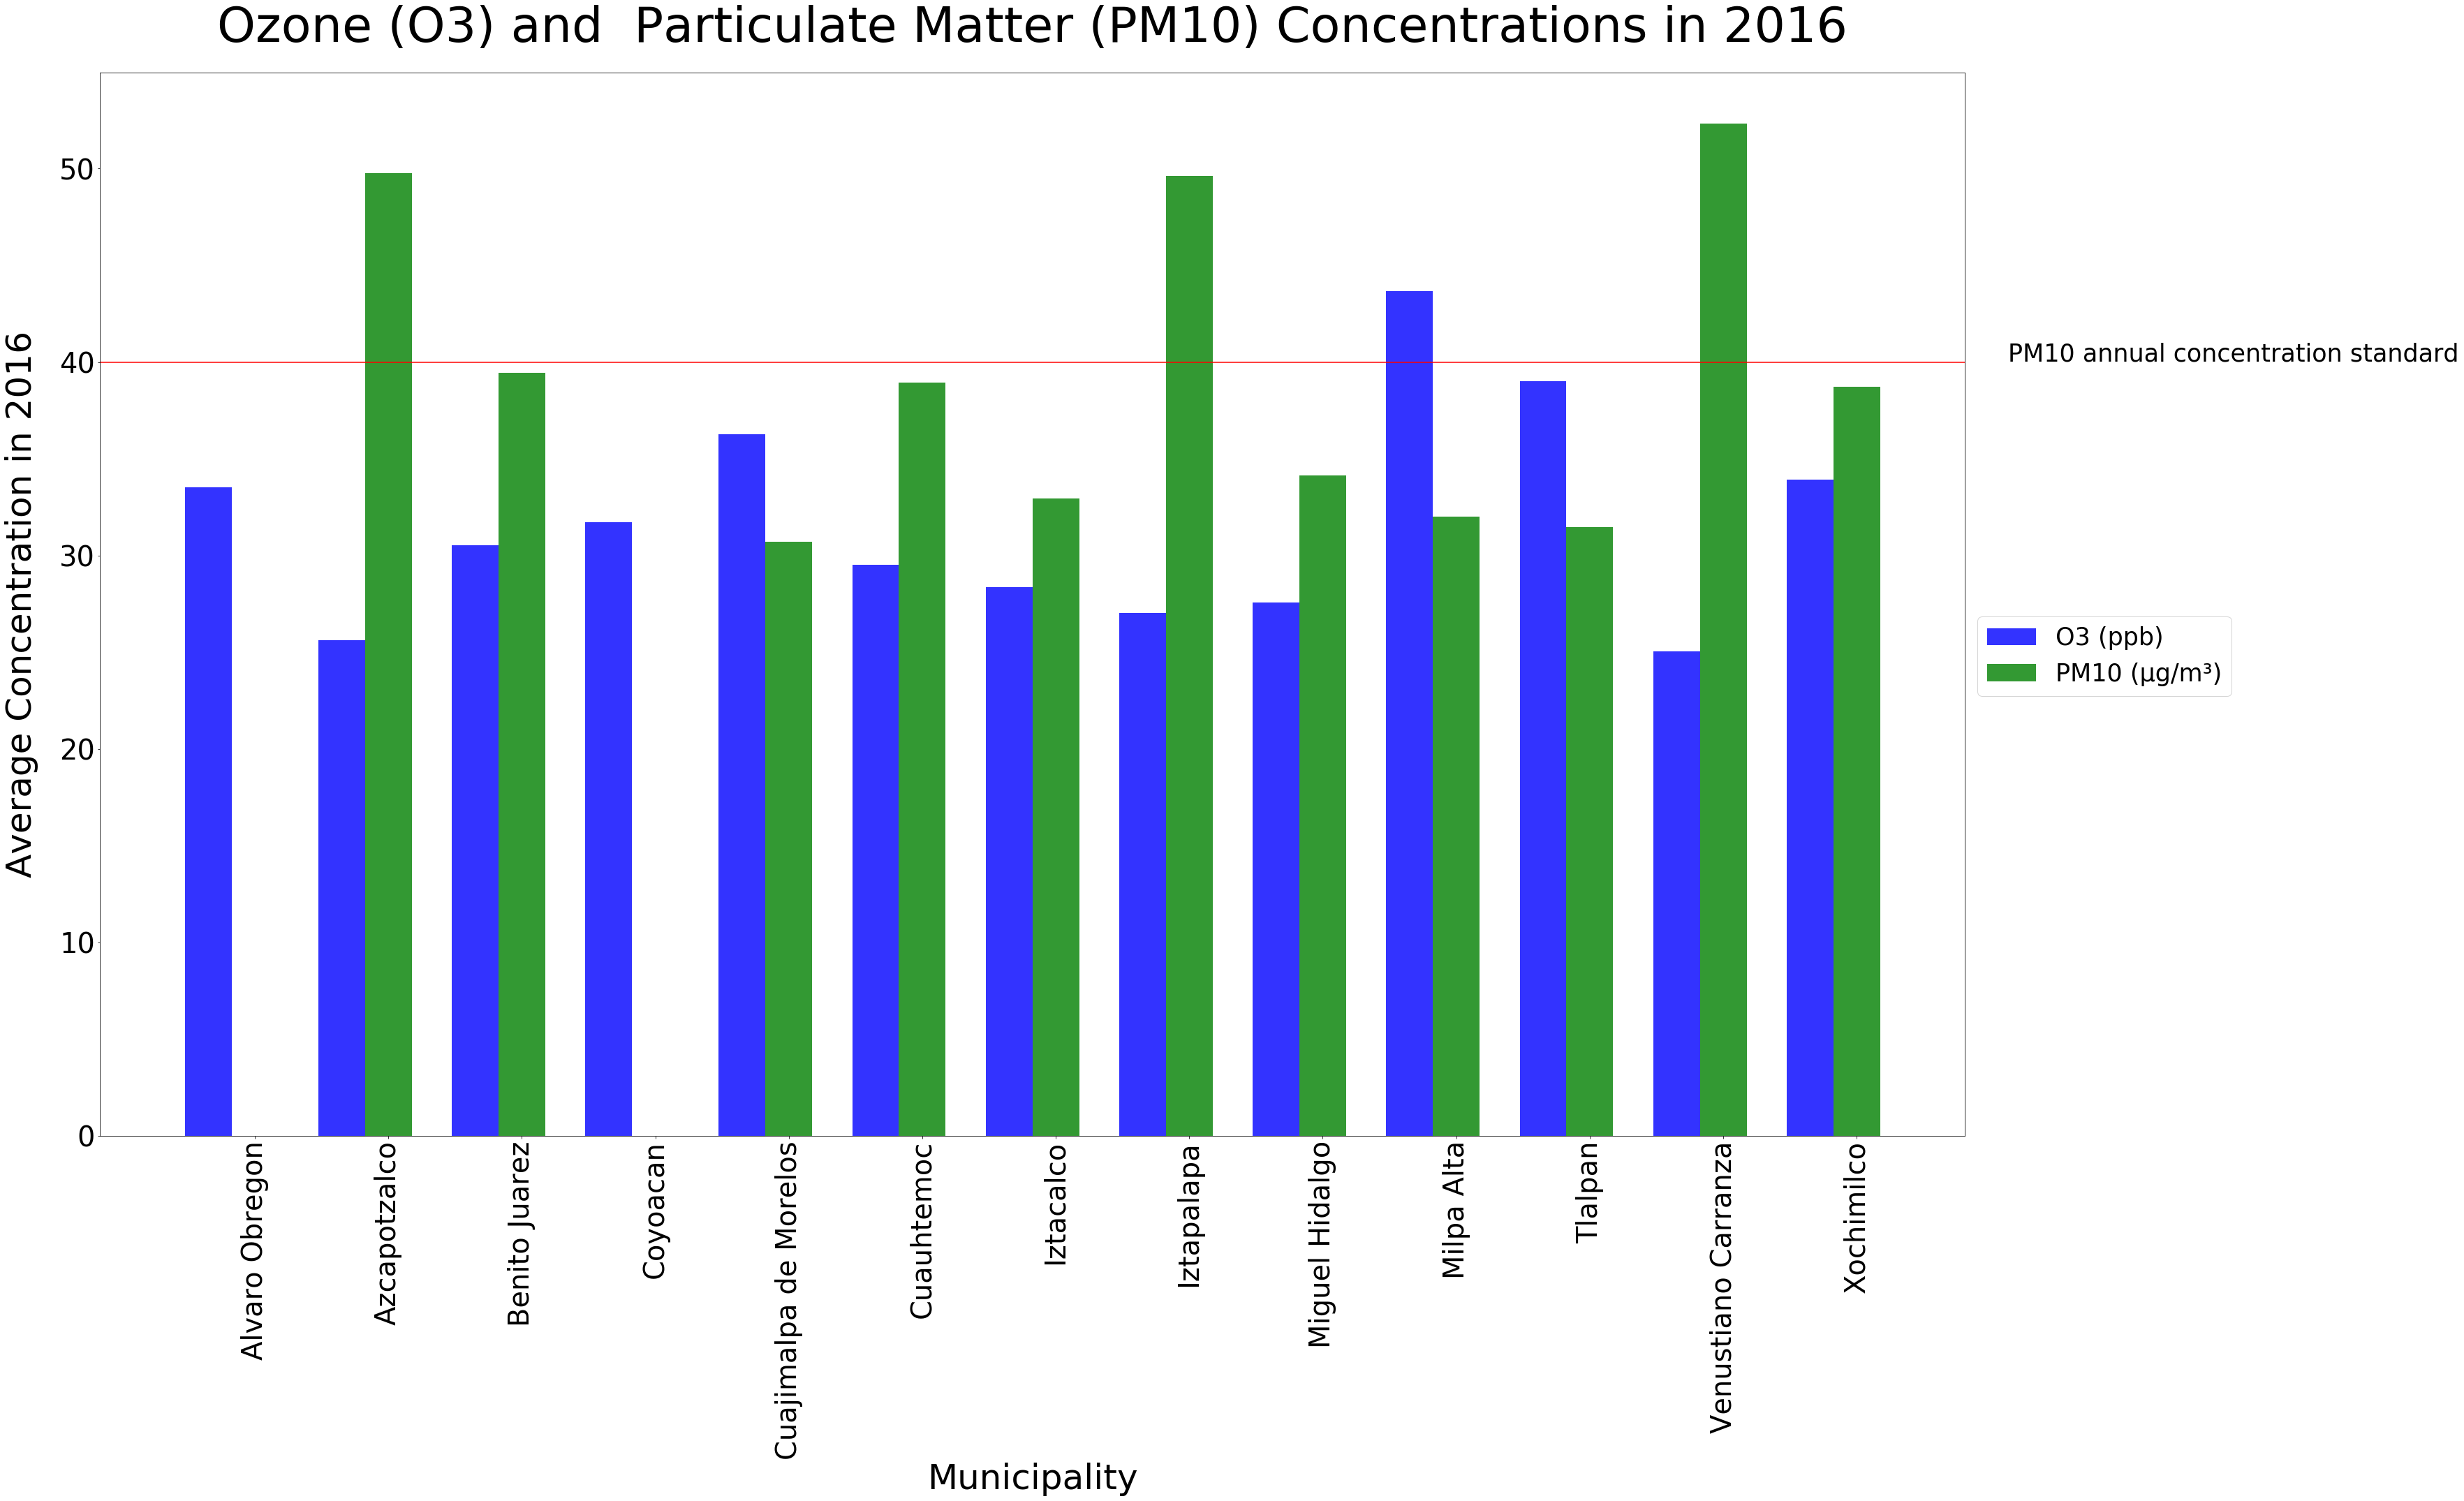

In [27]:
#Create a Bar chart with two parameters ozone and particle matter

n_groups = 13

O3 = o3 
PM10 = pm10

ind = np.arange(n_groups) 
# create plot
fig, ax = plt.subplots(figsize = (40,30))
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(ind, O3, bar_width, alpha=opacity, color='b',label='O3 (ppb)')
 
rects2 = plt.bar(ind + bar_width, PM10, bar_width, alpha=opacity, color='g', label='PM10 (µg/m³)')
 
plt.xlabel('Municipality', fontsize=50)
plt.ylabel('Average Concentration in 2016', fontsize=50, labelpad=30)
plt.title('Ozone (O3) and  Particulate Matter (PM10) Concentrations in 2016', fontsize =70,  y=1.025)
plt.xticks(ind + bar_width, index,rotation="vertical", fontsize = 40)
plt.yticks(fontsize = 40 )
plt.legend(bbox_to_anchor=(1, 0.5), fontsize=35, loc="best")
plt.tight_layout()
plt.axhline(y=40, color="r")
fig.text(1, .77, "PM10 annual concentration standard",
        verticalalignment='top', horizontalalignment='left',
        color='black', fontsize=35, rotation="horizontal")

plt.savefig("./images/Concentration in 2016.png", bbox_inches = 'tight')

plt.show()

Conclusions: 
* The most polluted municipalities regarding particle matter are: Venustiano Carranza, Iztapalapa and Azcapotzalco
* This three municipalities also overpassed the annual recommended limit
* The most polluted municipalities regarding ozone are: Milpa Alta, Tlalpan and Cuajimalpa de Morelos

***

# Respiratory emergencies

#### Extract information about respiratory emergencies in CDMX

In [20]:
urgencias = pd.read_csv('Resources/Urgencias_CDMX_respiratorias_date-corrected.csv')

In [21]:
urgencias['date'] = pd.to_datetime(urgencias['date'])

#### Extract general information about municipalities

In [22]:
delegaciones = pd.read_csv('Resources/delegaciones.csv')
delegaciones = delegaciones.set_index('DELEGACIÓN')
delegaciones

,ABREV,POBLACIÓN,SUPERFICIE (KM2),DENSIDAD (HAB7KM2)
DELEGACIÓN,,,,
ÁLVARO OBREGÓN,AO,749982,96.17,7799
AZCAPOTZALCO,AZC,400161,33.66,11888
BENITO JUÁREZ,BJ,417416,26.63,15675
COYOACÁN,COY,608479,54.40,11185
CUAJIMALPA DE MORELOS,CUAJ,199224,74.58,2671
CUAUHTÉMOC,CUAH,532553,32.40,16437
GUSTAVO A. MADERO,GAM,1164477,94.07,12379
IZTACALCO,IZC,390348,23.30,16753
IZTAPALAPA,IZT,1827868,117.00,15623


***

## Make a time series of respiratory diseases
Apply some filters if desired before graphing

#### Filter by Municipality


In [23]:
delegacion = 'TLALPAN'
urgencias_filtered = urgencias.loc[urgencias['NOMBRE DEL MUNICIPIO']==delegacion]

#### Filter by Age group - Children

In [24]:
max_age = 12
urgencias_filtered = urgencias.loc[urgencias['EDAD']<=max_age]

#### Filter by Age group - Elderly

In [25]:
min_age = 60
urgencias_filtered = urgencias.loc[urgencias['EDAD']>=min_age]

#### Filter by Specific Respiratory Disease

In [26]:
# First letters of disease code
code = "J45" # Example for asma
urgencias_filtered = urgencias.loc[urgencias['AFECPRIN'].str.startswith(code)==True]

***

### Time series with filtered data

In [27]:
# ----------------------------------------------- #
# Only in case no filters were previously applied #
# ----------------------------------------------- #
urgencias_filtered = urgencias

***

Select Municipality, in order to divide number of disease cases by entire population.<br>
<br>
Write "TOTAL" if for the whole city


In [28]:
municipality = 'TOTAL'
population_in_area = delegaciones['POBLACIÓN'][municipality]
population_in_area

8918653

In [29]:
# Present data as Number of cases per 100K
num_to_divide = 100000
population_per_100k = population_in_area/num_to_divide
population_per_100k

89.186530000000005

In [30]:
urgencias_sorted = urgencias_filtered.groupby('date')['AFECPRIN'].count().reset_index()
urgencias_sorted = urgencias_sorted.rename(columns={'AFECPRIN':'Cases'})
urgencias_sorted['Cases'] = urgencias_sorted['Cases']/population_per_100k

urgencias_sorted.head()


,date,Cases
0,2011-12-25,0.011212
1,2011-12-26,5.124092
2,2011-12-27,5.101667
3,2011-12-28,5.000755
4,2011-12-29,4.664381


***
### Calculate a Moving Average of 7 days.

In [31]:
urgencias_sorted['MA'] = urgencias_sorted['Cases'].rolling(7).mean()

***


## Graph of time series

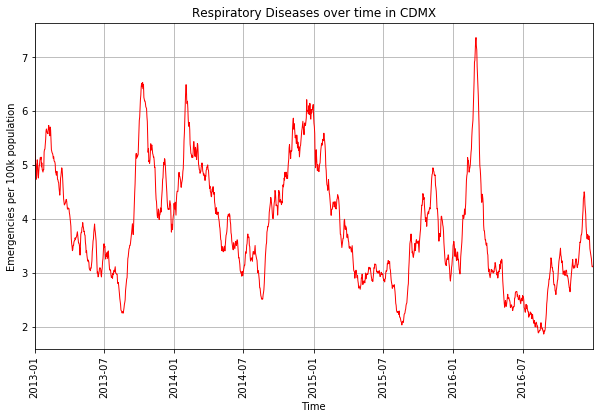

In [32]:
plt.figure(figsize =(10,6))

plt.title("Respiratory Diseases over time in CDMX")
plt.xlabel("Time")
plt.ylabel("Emergencies per 100k population")

# Add in a grid for the chart
plt.grid()

respiratory = plt.plot(urgencias_sorted['date'], urgencias_sorted['MA'], color='red', linewidth=1, label='Cases per 100k')

# Set x and y limits
plt.xlim('2013-01-01', '2016-12-31')
plt.xticks(rotation=90)

# Create a handle for each plot


# Set our legend to where the chart thinks is best
# plt.legend(handles=[fahrenheit, celcius], loc="best")

plt.savefig("Images/diseases_CDMX_all_respiratory.png")
plt.show()

The peak in early 2016 seems unseasonable. For this reason another graph will be constructed to observe the seasonality of respiratory diseases.

***

## Yearly cycles in respiratory emergencies

In [33]:
summary_global = pd.read_csv('Resources/summary_global.csv', encoding='UTF-8')
summary_global = summary_global.drop(columns='Unnamed: 0')
summary_global['date'] = pd.to_datetime(summary_global['date'])

TypeError: drop() got an unexpected keyword argument 'columns'

This table is a huge summary of:
* Total respiratory emergencies per 100k popullation in each municipality
* Cases of childhood asthma per 100k popullation in each municipality
* Daily average concentration of Ozone (O$_{3}$) in each municipality where there are records
* Daily average concentration of Particulate Matter < 10$\mu$m (PM10) in each municipality where there are records


***
### Create dataframe with moving average for each of the values

In [42]:
summary_global = summary_global.set_index('date')

In [43]:
summary_global_MA = summary_global.rolling(7, min_periods=3).mean()\
    .reset_index()
summary_global_MA['date'] = pd.to_datetime(summary_global_MA['date'])
summary_global_MA.head(5)
summary_global = summary_global.reset_index()

## Graph of yearly cycles 

In [44]:
y2016 = summary_global_MA.loc[summary_global_MA['date']>= '2016-01-01'] \
    .loc[summary_global_MA['date']<= '2016-12-30']
y2015 = summary_global_MA.loc[summary_global_MA['date']>= '2015-01-01'] \
    .loc[summary_global_MA['date']<= '2015-12-31']
y2014 = summary_global_MA.loc[summary_global_MA['date']>= '2014-01-01'] \
    .loc[summary_global_MA['date']<= '2014-12-31']
y2013 = summary_global_MA.loc[summary_global_MA['date']>= '2013-01-01'] \
    .loc[summary_global_MA['date']<= '2013-12-31']
y2012 = summary_global_MA.loc[summary_global_MA['date']>= '2012-01-01'] \
    .loc[summary_global_MA['date']<= '2012-12-30']

y2016 = y2016.loc[:,['date','Cases/100k_TOTAL']]
y2015 = y2015.loc[:,['date','Cases/100k_TOTAL']]
y2014 = y2014.loc[:,['date','Cases/100k_TOTAL']]
y2013 = y2013.loc[:,['date','Cases/100k_TOTAL']]
y2012 = y2012.loc[:,['date','Cases/100k_TOTAL']]

plt.figure(figsize =(10,6))

plt.title("Number of Emergencies per Month \n Mexico City (2012-2016)")
# plt.xlabel("Time")
plt.ylabel("Emergencies per 100k population")

plt.grid()

ur2016, = plt.plot(y2015['date'], y2016['Cases/100k_TOTAL'], color='red', linewidth=1.5, label='2016')
ur2015, = plt.plot(y2015['date'], y2015['Cases/100k_TOTAL'], color='green', linewidth=1, label='2015')
ur2014, = plt.plot(y2015['date'], y2014['Cases/100k_TOTAL'], color='royalblue', linewidth=1, label='2014')
ur2013, = plt.plot(y2015['date'], y2013['Cases/100k_TOTAL'], color='mediumpurple', linewidth=1, label='2013')
ur2012, = plt.plot(y2015['date'], y2012['Cases/100k_TOTAL'], color='orange', linewidth=1, label='2012')

x_ticks = np.array(['    Jan', '    Feb', '    Mar', '    Apr', '    May', '    Jun', 
                    '    Jul', '    Aug', '    Sep', '    Oct', '    Nov', '    Dec'])

x_locs = np.array(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', 
                   '2015-08', '2015-09', '2015-10', '2015-11', '2015-12'])


plt.xticks(labels=x_ticks, ticks=x_locs, ha='left')

plt.xlim(y2015['date'].min(), y2015['date'].max())

plt.legend(handles=[ur2016, ur2015, ur2014, ur2013, ur2012], loc='best')

plt.savefig('Images/CDMX_diseases several years.png')
plt.show()

AttributeError: Unknown property labels

The peak in February-March 2016 seems different than the general tendency in other years. It is suspected to be related to the several *Contingencias Ambientales* in 2016, which will be explored in the next session.

***
# Comparisson of Respiratory Diseases and Contaminant Concentration

## Graph of total respiratory emergencies and PM10 concentration in CDMX (2015-2016)


/Users/maribelojeda/anaconda/envs/pythonData2/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/maribelojeda/anaconda/envs/pythonData2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


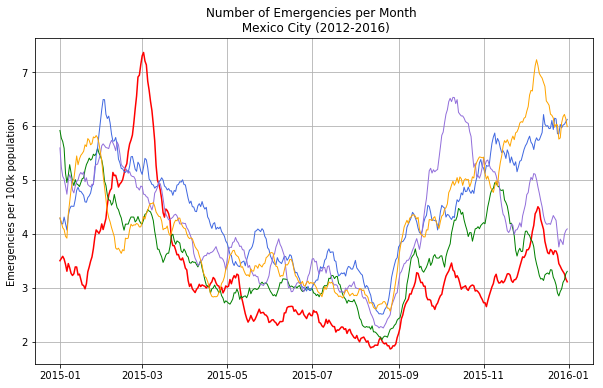

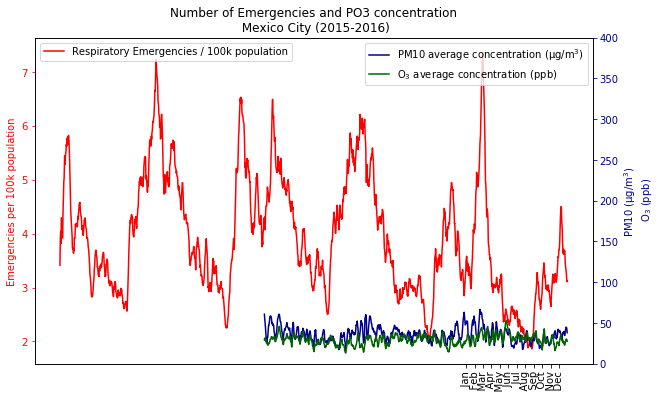

In [48]:
emergencies_PM10_MA = summary_global_MA[['date', 'Cases/100k_TOTAL', 'PM10_TOTAL_avg']] 
emergencies_PM10_MA['PM10_TOTAL_avg'] = emergencies_PM10_MA['PM10_TOTAL_avg']
emergencies_O3_MA = summary_global_MA[['date', 'Cases/100k_TOTAL', 'O3_TOTAL_avg']] 
emergencies_O3_MA['O3_TOTAL_avg'] = emergencies_O3_MA['O3_TOTAL_avg']

fig, ax1 = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(10)

plt.title("Number of Emergencies and PO3 concentration\n Mexico City (2015-2016)")


ax1.plot(emergencies_PM10_MA['date'], emergencies_PM10_MA['Cases/100k_TOTAL'], 
                   color='red', linewidth=1.5, label='Respiratory Emergencies / 100k population')
x_ticks = ['    Jan', '    Feb', '    Mar', '    Apr', '    May', '    Jun', 
                    '    Jul', '    Aug', '    Sep', '    Oct', '    Nov', '    Dec']
x_locs = np.array(['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', 
                   '2016-08', '2016-09', '2016-10', '2016-11', '2016-12'])
ax1.set_xlim(['2015-01-01', '2016-12-31'])
ax1.set_xticks(x_locs)
ax1.set_xticklabels(x_ticks, rotation=90)
ax1.set_ylabel("Emergencies per 100k population", color = 'r')
ax1.tick_params('y', colors = 'r')


ax2 = ax1.twinx()
ax2.plot(emergencies_PM10_MA['date'], emergencies_PM10_MA['PM10_TOTAL_avg'], 
                    color='darkblue', linewidth=1.5, label='PM10 average concentration (µg/m$^{3}$)')
ax2.plot(emergencies_O3_MA['date'], emergencies_O3_MA['O3_TOTAL_avg'], 
                    color='darkgreen', linewidth=1.5, label='O$_{3}$ average concentration (ppb)')
ax2.set_ylabel('PM10 (µg/m$^{3}$) \n O$_{3}$ (ppb)', color = 'darkblue')
ax2.tick_params('y', colors = 'darkblue')
ax2.set_ylim(0,400)



ax1.legend(loc='upper left')
plt.legend(loc='upper right')



plt.savefig('Images/PM10 AND O3_total respiratory_CDMX_NEWdata.png')
plt.show()

The previous graph shows no clear evidence that the respiratory emergencies and contaminants are related. However, it is misleading to consider all of Mexico City, since the contaminant concentrations can increase considerably in a more localized manner. Therefore the relation will be looked at in a municipality level.

***

# Boxplots
Some boxplots were created in order to visually show which municipalities show higher contaminant concentrations or respiratory emergencies. Data from 2014 to 2016 was considered.

In [49]:
Cases_columns = ['Cases/100k_ÁLVARO OBREGÓN', 'Cases/100k_AZCAPOTZALCO', 
       'Cases/100k_BENITO JUÁREZ', 'Cases/100k_COYOACÁN',
       'Cases/100k_CUAJIMALPA DE MORELOS', 'Cases/100k_CUAUHTÉMOC',
       'Cases/100k_GUSTAVO A. MADERO', 'Cases/100k_IZTACALCO', 
       'Cases/100k_IZTAPALAPA', 'Cases/100k_LA MAGDALENA CONTRERAS',
       'Cases/100k_MIGUEL HIDALGO', 'Cases/100k_MILPA ALTA',
       'Cases/100k_TLÁHUAC', 'Cases/100k_TLALPAN',
       'Cases/100k_VENUSTIANO CARRANZA',
       'Cases/100k_XOCHIMILCO', 'Cases/100k_TOTAL']
Asma_columns =  ['ASMA/100k_ÁLVARO OBREGÓN', 'ASMA/100k_AZCAPOTZALCO', 
       'ASMA/100k_BENITO JUÁREZ', 'ASMA/100k_COYOACÁN',
       'ASMA/100k_CUAJIMALPA DE MORELOS', 'ASMA/100k_CUAUHTÉMOC',
       'ASMA/100k_GUSTAVO A. MADERO', 'ASMA/100k_IZTACALCO', 
       'ASMA/100k_IZTAPALAPA', 'ASMA/100k_LA MAGDALENA CONTRERAS',
       'ASMA/100k_MIGUEL HIDALGO', 'ASMA/100k_MILPA ALTA',
       'ASMA/100k_TLÁHUAC', 'ASMA/100k_TLALPAN',
       'ASMA/100k_VENUSTIANO CARRANZA',
       'ASMA/100k_XOCHIMILCO', 'ASMA/100k_TOTAL']
O3_columns = ['O3_AZCAPOTZALCO','O3_BENITOJUAREZ','O3_COYOACAN','O3_CUAJIMALPA','O3_IZTACALCO',
             'O3_IZTAPALAPA','O3_MIGUELHIDALGO','O3_MILPAALTA','O3_TLALPAN','O3_VENUSTIANO',
             'O3_XOCHIMILCO','O3_CUAUHTEMOC','O3_OBREGON']
PM10_columns= ['PM10_AZCAPOTZALCO','PM10_BENITOJUAREZ','PM10_COYOACAN','PM10_CUAJIMALPA',
               'PM10_CUAUHTEMOC','PM10_IZTACALCO','PM10_IZTAPALAPA','PM10_MIGUELHIDALGO',
               'PM10_MILPAALTA','PM10_TLALPAN','PM10_VENUSTIANO','PM10_XOCHIMILCO','PM10_OBREGON'] 

In [50]:
summary_2014 = summary_global.loc[summary_global['date']>= '2014-01-01']

In [51]:
summary_2014_Cases = summary_2014[Cases_columns]
summary_2014_Asma  = summary_2014[Asma_columns]
summary_2014_O3    = summary_2014[O3_columns]
summary_2014_PM10  = summary_2014[PM10_columns]

## Total respiratory diseases

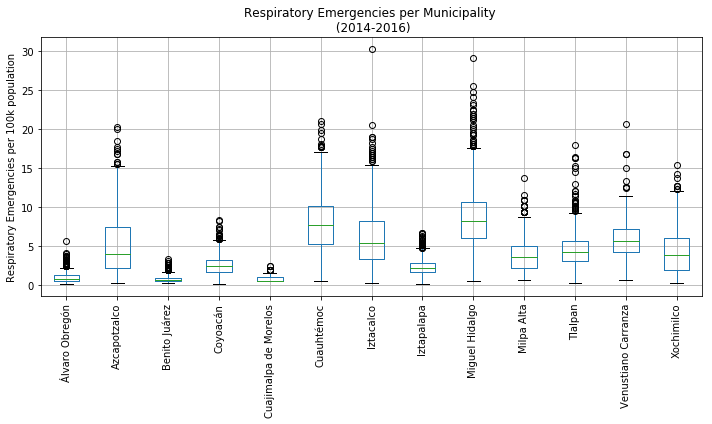

In [52]:
graphdata = summary_2014_Cases.rename(columns={'Cases/100k_AZCAPOTZALCO':'Azcapotzalco',
                'Cases/100k_BENITO JUÁREZ': 'Benito Juárez','Cases/100k_COYOACÁN':'Coyoacán',
                'Cases/100k_CUAJIMALPA DE MORELOS':'Cuajimalpa de Morelos', 'Cases/100k_CUAUHTÉMOC':'Cuauhtémoc',
                'Cases/100k_IZTACALCO':'Iztacalco','Cases/100k_IZTAPALAPA':'Iztapalapa',
                'Cases/100k_MIGUEL HIDALGO':'Miguel Hidalgo', 'Cases/100k_MILPA ALTA':'Milpa Alta',
                'Cases/100k_TLALPAN':'Tlalpan','Cases/100k_VENUSTIANO CARRANZA':'Venustiano Carranza',
                'Cases/100k_XOCHIMILCO':'Xochimilco','Cases/100k_ÁLVARO OBREGÓN':'Álvaro Obregón'})
cols = ['Álvaro Obregón', 'Azcapotzalco', 'Benito Juárez', 'Coyoacán', 'Cuajimalpa de Morelos', 
        'Cuauhtémoc', 'Iztacalco', 'Iztapalapa', 'Miguel Hidalgo', 'Milpa Alta', 'Tlalpan', 
        'Venustiano Carranza', 'Xochimilco']
graphdata = graphdata[cols]

# ----------------------------------------------------------------------------------------------------------------

plt.figure(figsize =(10,6))

plt.title("Respiratory Emergencies per Municipality \n (2014-2016)")
plt.ylabel("Respiratory Emergencies per 100k population")

plt.grid()

graphdata.boxplot(column= cols, rot=90)

plt.tight_layout()
plt.savefig('Images/boxplot_Resp-emergency.png')
plt.show()

Highest daily median respiratory emergencies were reported in Cuauhtémoc.

## Ozone

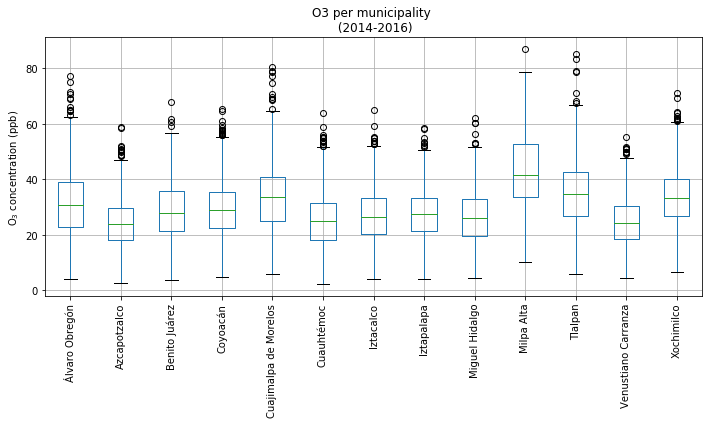

In [53]:
graphdata = summary_2014_O3.rename(columns={'O3_AZCAPOTZALCO':'Azcapotzalco',
                'O3_BENITOJUAREZ': 'Benito Juárez','O3_COYOACAN':'Coyoacán',
                'O3_CUAJIMALPA':'Cuajimalpa de Morelos', 'O3_CUAUHTEMOC':'Cuauhtémoc',
                'O3_IZTACALCO':'Iztacalco','O3_IZTAPALAPA':'Iztapalapa',
                'O3_MIGUELHIDALGO':'Miguel Hidalgo', 'O3_MILPAALTA':'Milpa Alta',
                'O3_TLALPAN':'Tlalpan','O3_VENUSTIANO':'Venustiano Carranza',
                'O3_XOCHIMILCO':'Xochimilco','O3_OBREGON':'Álvaro Obregón'})
cols = ['Álvaro Obregón', 'Azcapotzalco', 'Benito Juárez', 'Coyoacán', 'Cuajimalpa de Morelos', 
        'Cuauhtémoc', 'Iztacalco', 'Iztapalapa', 'Miguel Hidalgo', 'Milpa Alta', 'Tlalpan', 
        'Venustiano Carranza', 'Xochimilco']
graphdata = graphdata[cols]

# ----------------------------------------------------------------------------------------------------------------

plt.figure(figsize =(10,6))

plt.title("O3 per municipality \n (2014-2016)")
plt.ylabel("O$_{3}$ concentration (ppb)")

plt.grid()

graphdata.boxplot(column= cols, rot=90)
plt.tight_layout()

plt.savefig('Images/boxplot_O3.png')
plt.show()

Although Milpa Alta shows high Ozone concentrations, the contaminant data available is very little. Therefore, Tlalpan was analyzed, since it also has high Ozone concentration and more available data.

## PM10

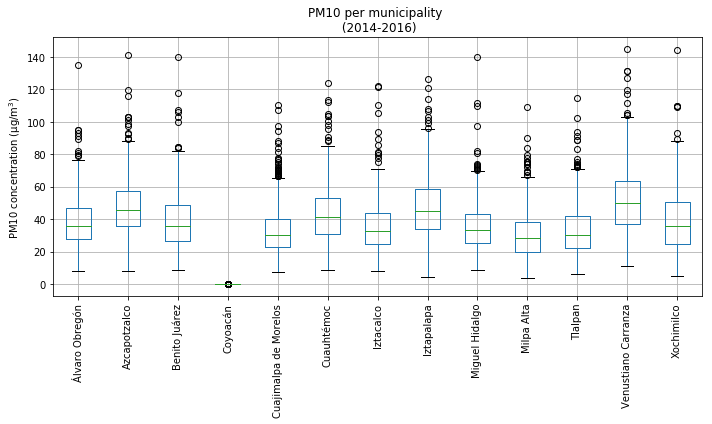

In [54]:
graphdata = summary_2014_PM10.rename(columns={'PM10_AZCAPOTZALCO':'Azcapotzalco',
                'PM10_BENITOJUAREZ': 'Benito Juárez','PM10_COYOACAN':'Coyoacán',
                'PM10_CUAJIMALPA':'Cuajimalpa de Morelos', 'PM10_CUAUHTEMOC':'Cuauhtémoc',
                'PM10_IZTACALCO':'Iztacalco','PM10_IZTAPALAPA':'Iztapalapa',
                'PM10_MIGUELHIDALGO':'Miguel Hidalgo', 'PM10_MILPAALTA':'Milpa Alta',
                'PM10_TLALPAN':'Tlalpan','PM10_VENUSTIANO':'Venustiano Carranza',
                'PM10_XOCHIMILCO':'Xochimilco','PM10_OBREGON':'Álvaro Obregón'})
cols = ['Álvaro Obregón', 'Azcapotzalco', 'Benito Juárez', 'Coyoacán', 'Cuajimalpa de Morelos', 
        'Cuauhtémoc', 'Iztacalco', 'Iztapalapa', 'Miguel Hidalgo', 'Milpa Alta', 'Tlalpan', 
        'Venustiano Carranza', 'Xochimilco']
graphdata = graphdata[cols]

# ----------------------------------------------------------------------------------------------------------------

plt.figure(figsize =(10,6))

plt.title("PM10 per municipality \n (2014-2016)")
plt.ylabel("PM10 concentration (µg/m$^{3}$)")

plt.grid()


graphdata.boxplot(column= cols, rot=90)
plt.tight_layout()

plt.savefig('Images/boxplot_PM10.png')
plt.show()

Venustiano Carranza is the municipality with highest median PM10 concentration, and therefore it will be looked in closer detail in the next section.

***
## Gausian filter

A Gaussian filter was applied to contaminant concentration to better observe trends.

## Graph of respiratory emergencies and Ozone in Tlalpan


In [55]:
fig, ax1 = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(10)

aux = summary_global[['date', 'Cases/100k_TLALPAN', 'O3_TLALPAN']]
aux['Cases/100k_TLALPAN'] = summary_global_MA['Cases/100k_TLALPAN']
aux = aux.loc[aux['date']>= '2015-01-01']
aux = aux.sort_values('date')
x  = aux['date']
y1 = aux['Cases/100k_TLALPAN']
y2_aux = aux['O3_TLALPAN']
y2_aux = y2_aux.fillna(y2_aux.mean(), limit=1)
y2_aux = y2_aux.interpolate()
y1 = y1.fillna(y1.mean(), limit=1)
y1 = y1.interpolate()

y2 = gaussian_filter1d(y2_aux, 5)


plt.title("Number of Emergencies and O$_{3}$ concentration\n Tlalpan (2015-2016)")
#--------------


ax1.plot(x, y1, color='red', linewidth=1.5, label='Respiratory Emergencies / 100k population')
x_ticks = ['    Jan', '    Feb', '    Mar', '    Apr', '    May', '    Jun', 
                    '    Jul', '    Aug', '    Sep', '    Oct', '    Nov', '    Dec']
x_locs = np.array(['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', 
                   '2016-08', '2016-09', '2016-10', '2016-11', '2016-12'])
ax1.set_xlim(['2015-01-01', '2016-12-31'])
ax1.set_xticks(x_locs)
ax1.set_xticklabels(x_ticks, rotation=90)
ax1.set_ylabel("Emergencies per 100k population", color = 'r')
ax1.tick_params('y', colors = 'darkblue')

ax2 = ax1.twinx()
ax2.plot(x, y2, color='darkgreen', linewidth=1.5, label='O$_{3}$ concentration (ppb)')
ax2.set_ylabel('PM10 (µg/m$^{3}$)', color = 'darkgreen')
ax2.tick_params('y', colors = 'darkgreen')
ax2.set_ylim(0,100)

# ax2.axhline(y=204, color='forestgreen', linewidth = 1, label= 'Extremely Bad Air Quality', alpha = 1)
# ax2.axhline(y=155, color='forestgreen', linewidth = 1, label= 'Very Bad Air Quality', alpha = 0.75)
ax2.axhline(y=95, color='forestgreen', linewidth = 1, label= 'Bad Air Quality', alpha = 0.5)

ax1.legend(loc='upper left')
plt.legend(loc='upper right')

plt.savefig('Images/O3_respiratory_TLALPAN_gausian.png')
plt.show()



/Users/maribelojeda/anaconda/envs/pythonData2/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


ValueError: could not convert string to float: '2016-12-31'

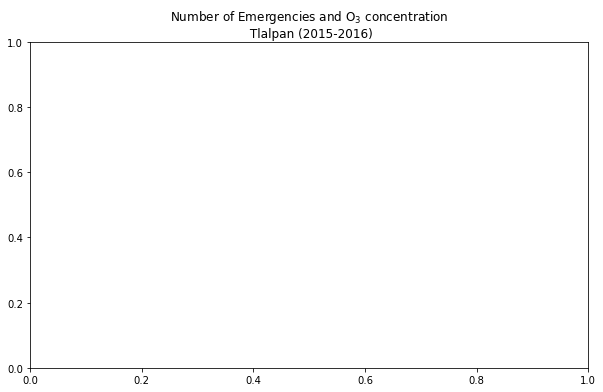

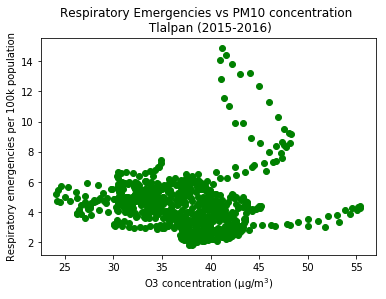

In [56]:
plt.figure(figsize=(6,4))

plt.title("Respiratory Emergencies vs PM10 concentration \n Tlalpan (2015-2016)")
plt.scatter(y2,y1, color="green")
plt.ylabel('Respiratory emergencies per 100k population')
plt.xlabel('O3 concentration (µg/m$^{3}$)')

plt.savefig('Images/correlation O3 Tlalpan.png')
plt.show()

In [57]:
from scipy import stats
r, p = stats.pearsonr(y2, y1)
print(f"R = {r} \np-value = {p}")

R = -0.021146689017489576 
p-value = 0.5681157891648195


There is no correlation observed between the Ozone concentration in Tlalpan and the number of daily respiratory emergencies.

## Graph of respiratory emergencies and PM10 in Tlalpan


In [58]:
fig, ax1 = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(10)

aux = summary_global[['date', 'Cases/100k_TLALPAN', 'PM10_TLALPAN']]
aux['Cases/100k_TLALPAN'] = summary_global_MA['Cases/100k_TLALPAN']
aux = aux.loc[aux['date']>= '2015-01-01']
aux = aux.sort_values('date')
x  = aux['date']
y1 = aux['Cases/100k_TLALPAN']
y2_aux = aux['PM10_TLALPAN']
y2_aux = y2_aux.fillna(y2_aux.mean(), limit=1)
y2_aux = y2_aux.interpolate()
y1 = y1.fillna(0)



y2 = gaussian_filter1d(y2_aux, 5)
# y3 = gaussian_filter1d(y3_aux, 5)


plt.title("Number of Emergencies and PM10 concentration\n Tlalpan (2015-2016)")



ax1.plot(x, y1, color='red', linewidth=1.5, label='Respiratory Emergencies / 100k population')
x_ticks = ['    Jan', '    Feb', '    Mar', '    Apr', '    May', '    Jun', 
                    '    Jul', '    Aug', '    Sep', '    Oct', '    Nov', '    Dec']
x_locs = np.array(['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', 
                   '2016-08', '2016-09', '2016-10', '2016-11', '2016-12'])
ax1.set_xlim(['2015-01-01', '2016-12-31'])
ax1.set_xticks(x_locs)
ax1.set_xticklabels(x_ticks, rotation=90)
ax1.set_ylabel("Emergencies per 100k population", color = 'r')
ax1.tick_params('y', colors = 'r')


ax2 = ax1.twinx()
ax2.plot(x, y2, color='darkblue', linewidth=1.5, label='PM10 concentration (µg/m$^{3}$)')
# ax2.plot(x, y3, color='darkgreen', linewidth=1.5, label='O$_{3}$ concentration (ppb)' )
ax2.set_ylabel('PM10 (µg/m$^{3}$)', color = 'darkblue')
ax2.tick_params('y', colors = 'darkblue')
ax2.set_ylim(20,100)





ax2.axhline(y=75, color='royalblue', linewidth = 1.5, label= 'Bad Air Quality', alpha = 0.5)
# ax2.axhline(y=214, color='royalblue', linewidth = 1.5, label= 'Very Bad Air Quality', alpha = 0.75)
# ax2.axhline(y=354, color='royalblue', linewidth = 1.5, label= 'Extremely Bad Air Quality', alpha = 1)

ax1.legend(loc='upper left')
plt.legend(loc='upper right')




plt.savefig('Images/PM10_respiratory_TLALPAN_gausian.png')
plt.show()


/Users/maribelojeda/anaconda/envs/pythonData2/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


ValueError: could not convert string to float: '2016-12-31'

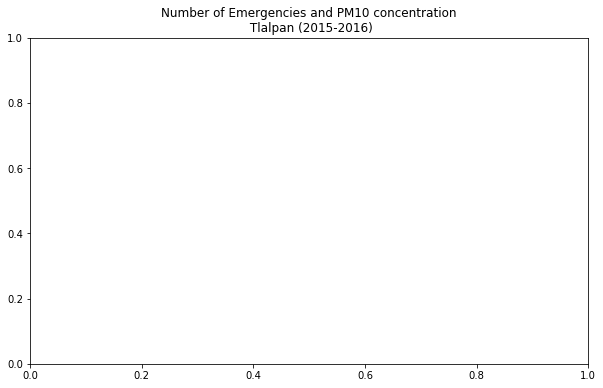

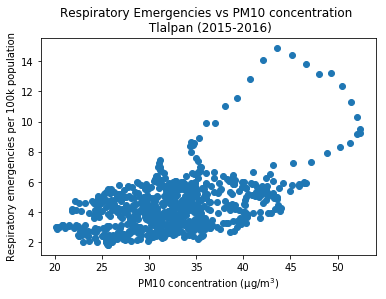

In [59]:
plt.figure(figsize=(6,4))

plt.title("Respiratory Emergencies vs PM10 concentration \n Tlalpan (2015-2016)")
plt.scatter(y2,y1)
plt.ylabel('Respiratory emergencies per 100k population')
plt.xlabel('PM10 concentration (µg/m$^{3}$)')

plt.savefig('Images/correlation PM10 TLALPAN.png')
plt.show()

In [60]:
from scipy import stats
r, p = stats.pearsonr(y2, y1)
print(f"R = {r} \np-value = {p}")

R = 0.4930657821100827 
p-value = 4.8120191804626166e-46


There seems to be a more significant correlation between PM10 and respiratory emergencies, even though the concentration of PM10 is not considerably high in Tlalpan. The same comparison will be made for Venustiano Carranza, which has much higher PM10 concentrations.

## Graph of respiratory emergencies and PM10 in Venustiano Carranza

Create sub-dataframe to graph

In [61]:
emergencies_PM10_Venustiano_MA = summary_global_MA[['date', 'Cases/100k_VENUSTIANO CARRANZA', 'PM10_VENUSTIANO']] 
emergencies_PM10_Venustiano_MA['PM10_VENUSTIANO'] = summary_global['PM10_VENUSTIANO']

/Users/maribelojeda/anaconda/envs/pythonData2/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
fig, ax1 = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(10)

aux = summary_global[['date', 'Cases/100k_VENUSTIANO CARRANZA', 'PM10_VENUSTIANO']]
aux['Cases/100k_VENUSTIANO CARRANZA'] = summary_global_MA['Cases/100k_VENUSTIANO CARRANZA']
aux = aux.loc[aux['date']>= '2015-01-01']
aux = aux.sort_values('date')
x  = aux['date']
y1 = aux['Cases/100k_VENUSTIANO CARRANZA']
y2_aux = aux['PM10_VENUSTIANO']
y2_aux = y2_aux.fillna(y2_aux.mean(), limit=1)
y2_aux = y2_aux.interpolate()


y2 = gaussian_filter1d(y2_aux, 5)



plt.title("Number of Emergencies and Contaminant concentration\n Venustiano Carranza (2015-2016)")

ax1.plot(x, y1, color='red', linewidth=1.5, label='Respiratory Emergencies / 100k population')
x_ticks = ['    Jan', '    Feb', '    Mar', '    Apr', '    May', '    Jun', 
                    '    Jul', '    Aug', '    Sep', '    Oct', '    Nov', '    Dec']
x_locs = np.array(['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', 
                   '2016-08', '2016-09', '2016-10', '2016-11', '2016-12'])
ax1.set_xlim(['2015-01-01', '2016-12-31'])
ax1.set_xticks(x_locs)
ax1.set_xticklabels(x_ticks, rotation=90)
ax1.set_ylabel("Emergencies per 100k population", color = 'r')
ax1.tick_params('y', colors = 'r')


ax2 = ax1.twinx()
ax2.plot(x, y2, color='darkblue', linewidth=1.5, label='PM10 concentration (µg/m$^{3}$)')
ax2.plot(x, y3, color='darkgreen', linewidth=1.5, label='O$_{3}$ concentration (ppb)' )
ax2.set_ylabel('PM10 (µg/m$^{3}$)', color = 'darkblue')
ax2.tick_params('y', colors = 'darkblue')
ax2.set_ylim(20,100)

ax2.axhline(y=75, color='royalblue', linewidth = 1.5, label= 'Bad Air Quality', alpha = 0.5)
# ax2.axhline(y=214, color='royalblue', linewidth = 1.5, label= 'Very Bad Air Quality', alpha = 0.75)
# ax2.axhline(y=354, color='royalblue', linewidth = 1.5, label= 'Extremely Bad Air Quality', alpha = 1)

ax1.legend(loc='upper left')
plt.legend(loc='upper right')

plt.savefig('Images/PM10_respiratory_Venustiano Carranza_gausian_.png')
plt.show()


/Users/maribelojeda/anaconda/envs/pythonData2/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


ValueError: could not convert string to float: '2016-12-31'

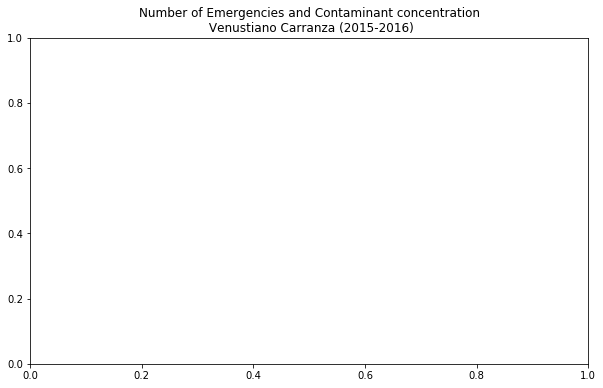

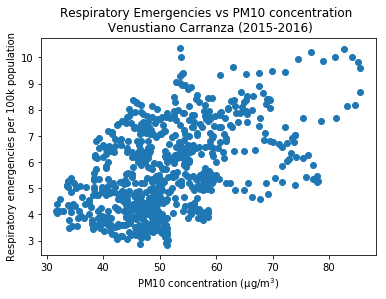

In [63]:
plt.figure(figsize=(6,4))

plt.title("Respiratory Emergencies vs PM10 concentration \n Venustiano Carranza (2015-2016)")
plt.scatter(y2,y1)
plt.ylabel('Respiratory emergencies per 100k population')
plt.xlabel('PM10 concentration (µg/m$^{3}$)')

plt.savefig('Images/correlation PM10 VENUSTIANO CARRANZA.png')
plt.show()

In [64]:
from scipy import stats
stats.pearsonr(y2, y1)

(0.49555132947490671, 1.4635394706550802e-46)

In [65]:
stats.kendalltau(y2,y1)

KendalltauResult(correlation=0.31206354687926624, pvalue=1.8107158886079188e-36)

The relation between PM10 and respiratory emergencies in Venustiano Carranza is observable in the graph. Even though the relation is not linear, it is clearly positive. There are other factors that also increase respiratory diseases (such as cold season), and for that reason, contamination alone does not fully explain the increase in respiratory emergencies throughout the analyzed period.

Keeping in mind that correlation does not imply causation, it is a plausible explanation for the increase in respiratory diseases, particularly in early 2016, when the highest PM10 concentrations were observed. It is also noteworthy that the peak in respiratory emergencies occurs slightly after the peak in PM10 concentration, further adding evidence to a possible relation. 

(Graphs for other municipalities are not presented in this notebook for the sake of brevity. However, other interesting municipalities can be found in the Images folder.)

***

# Locate dates of *Precontingencias* and *Contingencias Fase I* 

In [66]:
fig, ax1 = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(10)

aux = summary_global[['date', 'Cases/100k_TOTAL', 'PM10_TOTAL_avg', 'O3_TOTAL_avg']]
aux['Cases/100k_TOTAL'] = summary_global_MA['Cases/100k_TOTAL']
aux = aux.loc[aux['date']>= '2015-01-01']
aux = aux.sort_values('date')
x  = aux['date']
y1 = aux['Cases/100k_TOTAL']
y2_aux = aux['PM10_TOTAL_avg']
y2_aux = y2_aux.fillna(y2_aux.mean(), limit=1)
y2_aux = y2_aux.interpolate()
y3_aux = aux['O3_TOTAL_avg']
y3_aux = y3_aux.fillna(y2_aux.mean(), limit=1)
y3_aux = y3_aux.interpolate()

# df.fillna(df.mean())

# y1 = gaussian_filter1d(y1_aux, 7)
y2 = gaussian_filter1d(y2_aux, 5)
y3 = gaussian_filter1d(y3_aux, 5)

plt.title("Contaminant concentration\n CDMX (2015-2016)")

ax1.plot(x, y2, color='darkblue', linewidth=1.5, label='PM10 concentration (µg/m$^{3}$)')
x_ticks = ['    Jan', '    Feb', '    Mar', '    Apr', '    May', '    Jun', 
                    '    Jul', '    Aug', '    Sep', '    Oct', '    Nov', '    Dec']
x_locs = np.array(['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', 
                   '2016-08', '2016-09', '2016-10', '2016-11', '2016-12'])
ax1.set_xlim(['2015-01-01', '2016-12-31'])
ax1.set_xticks(x_locs)
ax1.set_xticklabels(x_ticks, rotation=90)
ax1.set_ylabel('PM10 (µg/m$^{3}$)', color = 'darkblue')
ax1.tick_params('y', colors = 'darkblue')
ax1.set_ylim(10,70)
# ax1.axhline(y=95, color='forestgreen', linewidth = 1, label= 'Bad Air Quality', alpha = 0.5)
# ax1.axhline(y=75, color='royalblue', linewidth = 1, label= 'Bad Air Quality', alpha = 0.5)




ax2 = ax1.twinx()
ax2.plot(x, y3, color='darkgreen', linewidth=1.5 )
ax2.set_ylabel('O$_{3}$ (ppb)', color = 'darkgreen')
ax2.tick_params('y', colors = 'darkgreen')
ax2.set_ylim(10,70)
#, label='O$_{3}$ concentration (ppb)'


ax2.axvline(x='2016-03-12', linewidth = 1.5, color='darkred', alpha = 1, label = 'Fase I')
ax2.axvline(x='2016-05-02', linewidth = 1.5, color='darkred', alpha = 1)
ax2.axvline(x='2016-05-14', linewidth = 1.5, color='darkred', alpha = 1)
ax2.axvline(x='2016-05-20', linewidth = 1.5, color='darkred', alpha = 1)
ax2.axvline(x='2016-05-24', linewidth = 1.5, color='darkred', alpha = 1)
ax2.axvline(x='2016-05-27', linewidth = 1.5, color='darkred', alpha = 1)
ax2.axvline(x='2016-05-31', linewidth = 1.5, color='darkred', alpha = 1)
ax2.axvline(x='2016-07-08', linewidth = 1.5, color='darkred', alpha = 1)
ax2.axvline(x='2016-08-11', linewidth = 1.5, color='darkred', alpha = 1)

ax2.axvline(x='2016-02-19', linewidth = 1, color='darkred', alpha = 0.5, label='Precontingencia')
ax2.axvline(x='2016-02-21', linewidth = 1, color='darkred', alpha = 0.5)
ax2.axvline(x='2016-03-12', linewidth = 1, color='darkred', alpha = 0.5)
ax2.axvline(x='2016-04-14', linewidth = 1, color='darkred', alpha = 0.5)
ax2.axvline(x='2016-04-05', linewidth = 1, color='darkred', alpha = 0.5)
ax2.axvline(x='2015-03-03', linewidth = 1, color='darkred', alpha = 0.5)
ax2.axvline(x='2015-04-08', linewidth = 1, color='darkred', alpha = 0.5)
ax2.axvline(x='2015-05-05', linewidth = 1, color='darkred', alpha = 0.5)
ax2.axvline(x='2015-05-09', linewidth = 1, color='darkred', alpha = 0.5)
ax2.axvline(x='2015-06-10', linewidth = 1, color='darkred', alpha = 0.5)
ax2.axvline(x='2015-10-04', linewidth = 1, color='darkred', alpha = 0.5)
ax2.axvline(x='2015-12-25', linewidth = 1, color='darkred', alpha = 0.5)


ax2.legend(loc='best')





plt.savefig('Images/PM10 and O3_respiratory_CDMX_gausian_contingency lines.png')
plt.show()

/Users/maribelojeda/anaconda/envs/pythonData2/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


ValueError: could not convert string to float: '2016-12-31'

During 2016 there were several air quality events reported in Mexico City. While the most serious ones were (*Contingencia Fase I*) were reported around the month of May due to high Ozone concentration, a relationship between Ozone and respiratory emergencies was not observed. 

The events reported in February and March 2016 (*Precontingencias*), on the other hand, were due to high PM10 concentrations. This dates are consistent with the increase in respiratory emergencies observed around the same time. 

***

# Summary and Conclussions
Even though the hypothesis pointed at Ozone as the most dangerous contaminant and the one most likely to be related to respiratory emergencies, the data showed a different story. When analyzing municipalities with high O$_3$ and PM10 concentrations, it was observed that the Ozone is not correlated with respiratory emergencies, while PM10 is. 

As a further analysis, data from less serious illnesses, meaning not deriving into a medical emergency or hospitalization should be looked at. This could possibly be achieved analyzing the volume of over-the-counter respiratory medications sales. More information of municipalities expected to be highly contaminated (such as Gustavo A. Madero) would also be valuable for a deeper analysis. 
